##### The cell below is for you to keep track of the libraries used and install those libraries quickly
##### Ensure that the proper library names are used and the syntax of `%pip install PACKAGE_NAME` is followed

In [9]:
%pip install pandas 
%pip install matplotlib
# add commented pip installation lines for packages used as shown above for ease of testing
# the line should be of the format %pip install PACKAGE_NAME 

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## **DO NOT CHANGE** the filepath variable
##### Instead, create a folder named 'data' in your current working directory and 
##### have the .csv file inside that. A relative path *must* be used when loading data into pandas

In [19]:
# Can have as many cells as you want for code
import pandas as pd
filepath = "./data/catA_train.csv" 
df = pd.read_csv("catA_train.csv")
# the initialised filepath MUST be a relative path to a folder named data that contains the parquet file

### **ALL** Code for machine learning and dataset analysis should be entered below. 
##### Ensure that your code is clear and readable.
##### Comments and Markdown notes are advised to direct attention to pieces of code you deem useful.

# 1.0 Processing Data


## Data Manipulation
- Remove rows where Company Status is 'Inactive'
- Removed features that are seemingly irrelevant to affecting the output by domain knowledge
    - We feel that this features have little information
- Grouped countries by continent 
     - This is to reduce the number of columns arising from one-hot encoding of 'Parent Country' to avoid the Curse of Dimensionality
- One-hot encoding of 'Continents'
- One-hot encoding for 'Parent Country', 'Entity Type', 'Ownership Type', 'Import/Export Status'
- Converted 'Year Found' to 'Years_Since_2024'
- Label encoding for 'Industry'
- Handling Missing Data
    - Before fitting the KNNImputer, we ensured that all non-numerical data was converted to numerical data
    - Initialize and fit the KNNImputer
        - KNNImputer imputes missing values by considering the values of k-nearest neighbors. This approach helps to preserve patterns and relationships present in the data, making it suitable for our dataset where neighboring points are likely to have similar characteristics.
- Feature Selection to remove Low-Variance Features
    - Reduced features from 30 to 16





In [10]:

import pandas as pd
import matplotlib.pyplot as plt
import pycountry_convert as pc
import warnings
# Remove rows where the Company Status is 'Inactive'
df1 = df[df['Company Status (Active/Inactive)'] == 'Active']

df1 = df.drop(columns=['Square Footage','8-Digit SIC Description','Company Description','LATITUDE','LONGITUDE','AccountID','Company',
                '8-Digit SIC Code','Parent Company','Global Ultimate Country', 
                'Fiscal Year End', 'Global Ultimate Company', 'Domestic Ultimate Company'], inplace=False)

# Grouping Countries by Continent 
def country_to_continent(country_name):
    warnings.filterwarnings("ignore", message="Country's official_name not found.")
    warnings.filterwarnings("ignore", message="Country's common_name not found.")
    if country_name == "Hong Kong SAR":
        return 'Asia'
    
    if country_name == "Virgin Islands (British)":
        return 'Europe'
    
    if country_name == "Curacao":
        return 'South America'

    try:
        # Get the alpha-2 country code
        country_alpha2 = pc.country_name_to_country_alpha2(country_name)
        # Get the continent code from the country code
        continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        # Convert the continent code to continent name
        continent_name = pc.convert_continent_code_to_continent_name(continent_code)
        return continent_name
    except LookupError:
        return "Not Found"
    except:
        return "Unknown"  # Return country name if the country name is not found
    
# Apply the function to the 'Parent Country' column to create a new 'Continent' column
df1['Continent'] = df1['Parent Country'].apply(country_to_continent)

# Use get_dummies to one-hot encode the 'Continent' column
one_hot_encoded_data = pd.get_dummies(df1['Continent'], prefix='Continent')

# Join the one-hot encoded data back to the original DataFrame
df1 = df1.join(one_hot_encoded_data)

#Convert to 0 and 1s
df1['Continent_Africa'] = df1['Continent_Africa'].astype(int)
df1['Continent_Asia'] = df1['Continent_Asia'].astype(int)
df1['Continent_Europe'] = df1['Continent_Europe'].astype(int)
df1['Continent_North America'] = df1['Continent_North America'].astype(int)
df1['Continent_South America'] = df1['Continent_South America'].astype(int)
df1['Continent_Oceania'] = df1['Continent_Oceania'].astype(int)
df1 = df1[df1['Continent'] != 'South America']
df1 = df1[df1['Continent'] != 'Unknown']

# One-Hot encoding for Entity Type', 'Ownership Type', 'Import/Export Status' 
df1 = pd.get_dummies(df1, columns=['Entity Type'], prefix='Entity_Type')
df1 = pd.get_dummies(df1, columns=['Ownership Type'], prefix='Ownership_Type')
df1 = pd.get_dummies(df1, columns=['Import/Export Status'], prefix='Import_Export_Status')

# Convert dummy variables to 0 and 1s 
df1['Ownership_Type_Non-Corporates'] = df1['Ownership_Type_Non-Corporates'].astype(int)
df1['Ownership_Type_Nonprofit'] = df1['Ownership_Type_Nonprofit'].astype(int)
df1['Ownership_Type_Partnership'] = df1['Ownership_Type_Partnership'].astype(int)
df1['Ownership_Type_Private'] = df1['Ownership_Type_Private'].astype(int)
df1['Ownership_Type_Public'] = df1['Ownership_Type_Public'].astype(int)
df1['Ownership_Type_Public Sector'] = df1['Ownership_Type_Public Sector'].astype(int)
df1['Import_Export_Status_Both Imports & Exports'] = df1['Import_Export_Status_Both Imports & Exports'].astype(int)
df1['Import_Export_Status_Imports'] = df1['Import_Export_Status_Imports'].astype(int)
df1['Import_Export_Status_Exports'] = df1['Import_Export_Status_Exports'].astype(int)

# Convert 'Year Found' to 'Years_Since_2024'
df1['Years_From_2024'] = 2024 - df1['Year Found']
df1.drop(columns=['Year Found'], inplace=True)

 # Label encoding for 'Industry'
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df1['Industry'] = label_encoder.fit_transform(df1['Industry'])

# Removing non-numerical columns
df2 = df1.drop(columns=['Parent Country', 'Company Status (Active/Inactive)', 'Continent'], inplace=False)

# Convert into Dataframe
df3 = pd.DataFrame(df2)

from sklearn.impute import KNNImputer
# Initialize and fit the KNNImputer
imputer = KNNImputer(n_neighbors=10)
df_imputed = imputer.fit_transform(df3)

# Transform the data
df_imputed = pd.DataFrame(df_imputed, columns=df3.columns)

#To see output of imputed data: df_imputed.to_csv('imputed_file.csv', index=False)

# Feature Selection to remove Low-Variance Features

from sklearn.feature_selection import VarianceThreshold
from sklearn.datasets import make_classification

# Initialize the VarianceThreshold with a threshold value of 0.1
threshold_value = 0.05
selector = VarianceThreshold(threshold=threshold_value)

# Fit and transform the dataset
correlation_df_selected = selector.fit_transform(df_imputed)

# Get the selected feature indices
selected_feature_indices = selector.get_support()

# Filter the columns in the original DataFrame based on the selected features
selected_feature_columns = df_imputed.columns[selected_feature_indices]
df_selected = df_imputed[selected_feature_columns]

# Display the dataset after variance thresholding
df_selected = pd.DataFrame(df_selected)
df_selected.head()

,SIC Code,Industry,Employees (Single Site),Employees (Domestic Ultimate Total),Employees (Global Ultimate Total),Sales (Domestic Ultimate Total USD),Sales (Global Ultimate Total USD),Is Domestic Ultimate,Is Global Ultimate,Continent_Asia,Continent_Europe,Entity_Type_Parent,Entity_Type_Subsidiary,Import_Export_Status_Both Imports & Exports,Import_Export_Status_Exports,Years_From_2024
0,7361.0,157.0,15.0,25.0,42.2,2.209224e+06,4.637871e+06,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,4.0
1,4449.0,565.0,39.0,100.0,100.0,7.093536e+09,7.093536e+09,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,9.0
2,6719.0,373.0,4.0,4.0,4.0,1.026308e+06,1.026308e+06,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,31.0
3,6719.0,373.0,10.0,100.0,100.0,7.339898e+10,7.339898e+10,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,18.0
4,6719.0,373.0,40.0,4.0,4.0,4.322130e+05,4.322130e+05,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,18.0


'Square Footage': Dropped as it was an empty column

'8-Digit SIC Description': Redundant as SIC code is present, as the description might not provide additional predictive power beyond the coded information.

'Company Description': Text descriptions require complex natural language processing to be useful in a predictive model, which might not be justified if the predictive gain is minimal.

'LATITUDE' and 'LONGITUDE': Geographic coordinates were too specific and we chose to focus on the continents where companies were located as a whole.

'AccountID': Usually a unique identifier for each record that does not hold any predictive power.

'Company': The company's name is often unique to each entity and doesn't provide quantitative value for sales predictions.

'8-Digit SIC Code': Redundant as SIC code is present as industry classification does not show significant variance in sales or is not a key factor in sales differences.

'Parent Company': If the sales are more influenced by the company's own operations rather than its corporate relationships, this might be less relevant.

'Global Ultimate Country': Could be irrelevant if global location is not a determinant for the company's sales.

'Fiscal Year End': May not correlate directly with sales, especially if fiscal year timing varies widely across companies without a clear pattern.

'Global Ultimate Company' and 'Domestic Ultimate Company': These might be dropped to avoid multicollinearity as the model aims to predict based on operational data rather than corporate structure.

# 1.1 Data Visualisation

## Correlation Matrix

In [12]:
 
# Create a correlation matrix
correlation_matrix = df_selected.corr()

# Convert matrix to dataframe
correlation_df = pd.DataFrame(correlation_matrix)
correlation_df


,SIC Code,Industry,Employees (Single Site),Employees (Domestic Ultimate Total),Employees (Global Ultimate Total),Sales (Domestic Ultimate Total USD),Sales (Global Ultimate Total USD),Is Domestic Ultimate,Is Global Ultimate,Continent_Asia,Continent_Europe,Entity_Type_Parent,Entity_Type_Subsidiary,Import_Export_Status_Both Imports & Exports,Import_Export_Status_Exports,Years_From_2024
SIC Code,1.000000,-0.049967,-0.056331,-0.018850,0.002724,-0.011263,-0.015194,0.019648,0.090297,0.015527,-0.034311,0.102445,-0.102797,-0.269729,0.008221,-0.190755
Industry,-0.049967,1.000000,-0.027873,-0.003519,-0.023759,0.017733,-0.012626,-0.048150,0.069583,0.082388,-0.069623,0.089364,-0.089911,-0.079987,-0.062326,-0.001055
Employees (Single Site),-0.056331,-0.027873,1.000000,0.157654,0.010159,0.005174,0.006403,-0.038351,-0.044257,-0.001362,0.003271,-0.043056,0.042178,0.032849,0.033323,0.066743
Employees (Domestic Ultimate Total),-0.018850,-0.003519,0.157654,1.000000,0.018975,0.016140,0.022385,-0.059420,-0.043938,0.011036,-0.005243,-0.037419,0.036595,0.013818,0.011836,0.045905
Employees (Global Ultimate Total),0.002724,-0.023759,0.010159,0.018975,1.000000,-0.000128,0.655323,0.065192,-0.094239,-0.161067,0.131077,-0.094543,0.094850,0.040445,0.023894,0.028095
Sales (Domestic Ultimate Total USD),-0.011263,0.017733,0.005174,0.016140,-0.000128,1.000000,0.099151,-0.056074,-0.040011,-0.002104,0.009228,-0.038099,0.038170,0.001201,-0.009294,-0.015218
Sales (Global Ultimate Total USD),-0.015194,-0.012626,0.006403,0.022385,0.655323,0.099151,1.000000,0.040256,-0.097128,-0.144891,0.102992,-0.095486,0.095778,0.034278,0.014751,0.021951
Is Domestic Ultimate,0.019648,-0.048150,-0.038351,-0.059420,0.065192,-0.056074,0.040256,1.000000,0.584970,-0.425831,0.339577,0.517343,-0.517424,0.118180,0.031115,-0.088020
Is Global Ultimate,0.090297,0.069583,-0.044257,-0.043938,-0.094239,-0.040011,-0.097128,0.584970,1.000000,0.227696,-0.188701,0.943235,-0.940497,-0.056108,-0.057207,-0.117990
Continent_Asia,0.015527,0.082388,-0.001362,0.011036,-0.161067,-0.002104,-0.144891,-0.425831,0.227696,1.000000,-0.797067,0.244249,-0.244478,-0.112192,-0.084810,0.000206


## Visualisation of Correlation Matrix using Seaborn Heatmaps

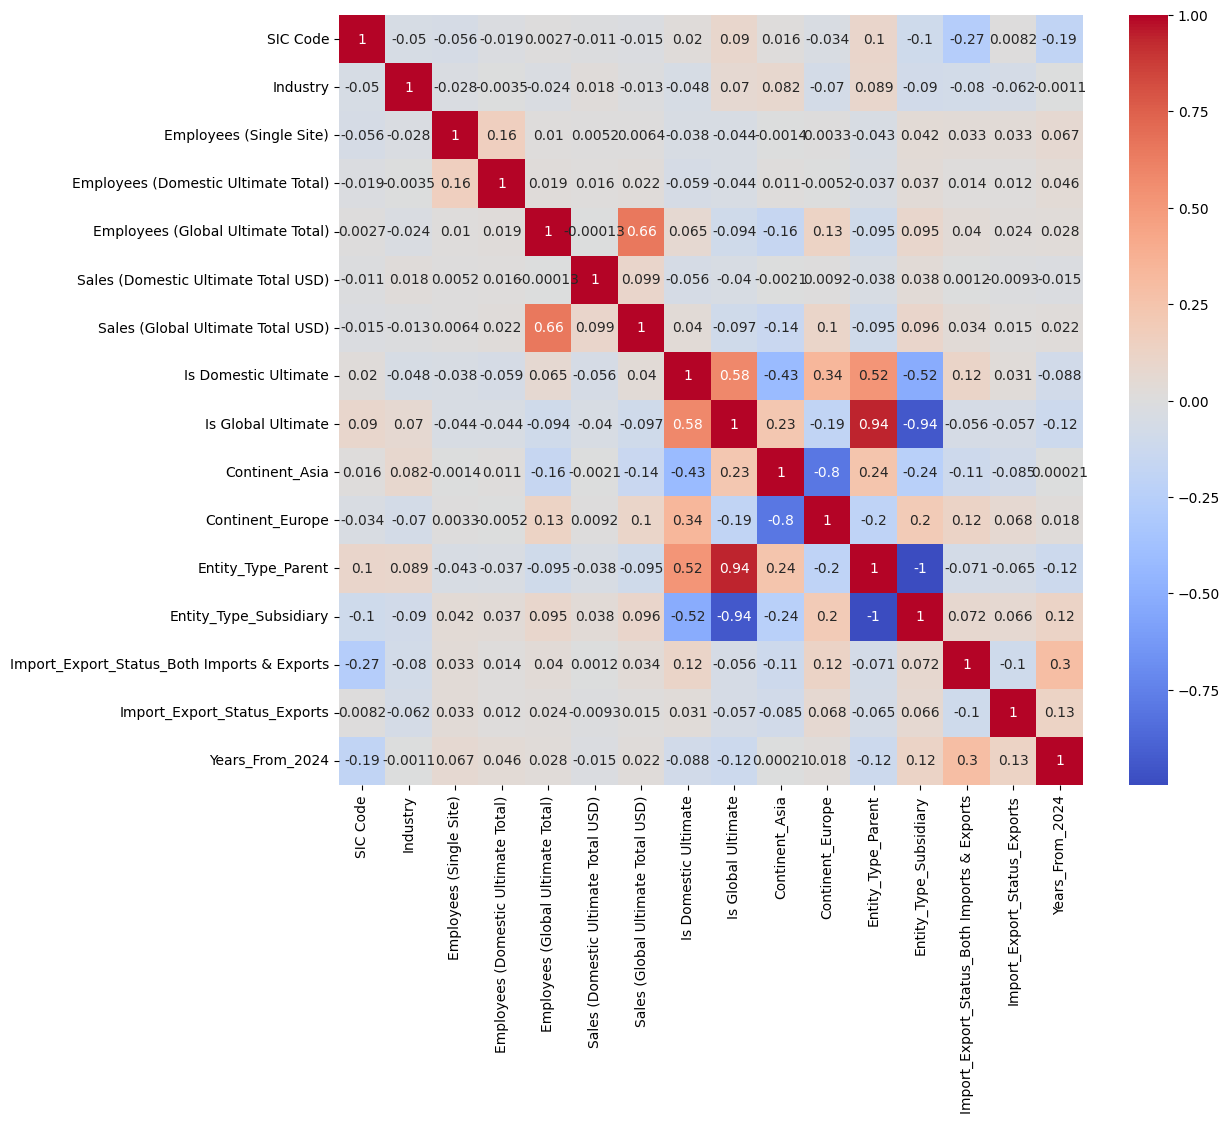

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

#heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df_selected.corr(), annot=True, cmap='coolwarm')
plt.show()

Firstly, we observe that the "Sales (Domestic Ultimate Total USD)" and "Sales (Global Ultimate Total USD)" columns have strong correlations with several variables, which suggests these factors may be influential in predicting sales outcomes. For instance, "Employees (Global Ultimate Total)" has a notable positive correlation (0.66) with "Sales (Global Ultimate Total USD)", indicating that as the number of employees increases globally, there might be a tendency for global sales to increase as well.

Conversely, certain variables such as "SIC Code" and "Industry" demonstrate very low correlation with sales figures, suggesting that they have little linear predictive power in relation to sales within this dataset.

We also see interesting relationships between geographic variables and sales. "Continent_Europe" shows a moderate positive correlation with "Sales (Global Ultimate Total USD)" at 0.34, hinting at the possibility that European presence or market penetration could be a factor in driving global sales. This might reflect market dynamics or consumer behavior that is unique to Europe.

Other observations include "Is Domestic Ultimate" has correlations with both "Sales (Domestic Ultimate Total USD)" and "Sales (Global Ultimate Total USD)" at around 0.58 and 0.52, respectively. These moderate positive correlations suggest that whether a company is designated as a domestic ultimate might have a notable influence on its sales performance, both domestically and globally. However, the relationship is stronger with domestic sales, which could be due to domestic companies having a firmer foothold in their local markets.

Additionally, "Entity_Type_Parent" and "Entity_Type_Subsidiary" are inversely correlated at -0.94, which is among the strongest negative correlations in the matrix. This indicates a clear dichotomy within the dataset, where entities are either classified strongly as one or the other, but rarely both. This distinction might have implications for hierarchical corporate structures and their operational efficiencies, which in turn could affect sales figures indirectly.

High correlation coefficients do not necessarily imply causation, and low correlation does not mean a variable is not important – it could be that its relationship with sales is non-linear or influenced by other factors not included in the matrix.It's important to remember that these are linear correlations, and they only measure the strength of a straight-line relationship between two variables. Some relationships may be more complex and non-linear, which would not be captured well by a correlation coefficient. Additionally, certain variables might interact with each other in ways that affect their individual correlations with sales.

# 1.2 Models

## Linear Regression Model

In [ ]:

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import r2_score
# create linear regression object
mlr = LinearRegression()

#defined the input variables, X independent variable, Y dependent variable
X = df_selected.drop(columns= 'Sales (Domestic Ultimate Total USD)') #all other columns except domestic sales 
y = df_selected['Sales (Domestic Ultimate Total USD)']

X_train,X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 100)


# fit linear regression
mlr.fit(X_train, y_train)

#intercept of the line of best fit
print("Intercept: ", mlr.intercept_)

print("Coefficients: ", mlr.coef_)
list(zip(X, mlr.coef_)) #pair the feature names with the coefficients

#Predicting the Test and Train set result 
y_pred= mlr.predict(X_test)  
x_pred= mlr.predict(X_train) 

print("Prediction for test set: {}".format(y_pred))
#Actual value and the predicted value
reg_model_diff = pd.DataFrame({'Actual value': y_test, 'Predicted value': y_pred})
reg_model_diff

from sklearn import metrics

mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)



print('Mean Absolute Error:', mae)
print('Mean Square Error:', mse)
print('Root Mean Square Error:', rmse)
print("R-squared:", r2)


## 

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor, XGBRFRegressor


features = df_selected.drop(columns= ['Sales (Domestic Ultimate Total USD)'])
target = df_selected['Sales (Domestic Ultimate Total USD)']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

def initial_model(regressor, X_train, y_train):
  model = regressor
  model.fit(X_train, y_train)
  return model

#Prints the models accuracy
def model_accuracy(model, X_test, y_test):
  y_preds = model.predict(X_test)
  MAE = mean_absolute_error(y_test, y_preds)
  R2 = r2_score(y_test, y_preds)
  MAPE = mean_absolute_percentage_error(y_test, y_preds)
  print(str(model) + '\nPerformance:')
  print(f'MAE: {round(MAE,2)}')
  print(f'R2: {round(R2, 4) * 100}')
  print(f'MAPE: {round(MAPE * 100,2)}%')

X_train shape: (22926, 15)
y_train shape: (22926,)
X_test shape: (5732, 15)
y_test shape: (5732,)


Linear Regression is a simple and widely-used algorithm for regression tasks. It models the relationship between a dependent variable and independent variables using a linear equation. The goal is to find the best-fitting line that minimizes the difference between predicted and actual values.

In [16]:
#Uses GridSearchCV and returns model with the best parameters already fitted
def best_grid_model(regressor, params, X_train, y_train):
  initial_model = regressor
  model = GridSearchCV(initial_model, params, refit=True, verbose=3)
  model.fit(X_train, y_train)
  print('Best Parameters for ' + str(regressor) + ': '+ str(model.best_params_))
  return model

  #Uses RandomizedSearchCV and returns model with the best parameters already fitted
def best_random_model(regressor, params, X_train, y_train):
  initial_model = regressor
  model = RandomizedSearchCV(initial_model, params, refit=True, verbose=3)
  model.fit(X_train, y_train)
  print('Best Parameters for ' + str(regressor) + ': '+ str(model.best_params_))
  return model

# Show difference between untuned and tuned
def show_upgrade(model_1, model_2):
  print('Initial Model performance:')
  print('-------------------')
  model_accuracy(model_1, X_test,y_test)
  print()
  print('Model performance fter Hyperparameter Tuning:')
  print('-------------------')
  model_accuracy(model_2, X_test,y_test)

  


In [ ]:
#DECISION TREE MODEL 

#INITIAL MODEL 
DTR_model = initial_model(DecisionTreeRegressor(), X_train, y_train)
model_accuracy(DTR_model, X_test, y_test)

#hyperparameter tuning
params1 = {
    'max_depth': [200, 400, 600, 800, 1000],
    'max_leaf_nodes': [1000, 1250, 1500, 1750, 2000],
    'min_samples_split': [8, 10, 12, 18, 20, 16],
} 

DTR_model1 = best_grid_model(DecisionTreeRegressor(), params1, X_train, y_train)
model_accuracy(DTR_model1, X_test, y_test)

#further tuning of hyperparameter based on prev results
params2 = {
    'max_depth': [160, 180, 200, 220, 240],
    'max_leaf_nodes': [1250, 1500, 1750, 2000, 2250],
    'min_samples_split': [6, 7, 8, 9, 10],
} 
DTR_model2 = best_grid_model(DecisionTreeRegressor(), params2, X_train, y_train)
model_accuracy(DTR_model2, X_test, y_test)

#further tuning of hyperparameter based on prev results
params3 = {
    'max_depth': [200, 220, 240, 260, 280],
    'max_leaf_nodes': [1750, 2000, 2250, 2500, 2750],
    'min_samples_split': [6, 7, 8, 9, 10],
} 

DTR_model3 = best_grid_model(DecisionTreeRegressor(), params3, X_train, y_train)
model_accuracy(DTR_model3, X_test, y_test)
#further tuning of hyperparameter based on prev results
params4 = {
    'max_depth': [220, 240, 260, 280, 300],
    'max_leaf_nodes': [2250, 2500, 2750, 3000, 3250],
    'min_samples_split': [8, 9, 10, 11, 12],
}

DTR_model4 = best_grid_model(DecisionTreeRegressor(), params4, X_train, y_train)
model_accuracy(DTR_model4, X_test, y_test)

params5 = {
    'max_depth': [240, 260, 280, 300, 320],
    'max_leaf_nodes': [2750, 3000, 3250, 3500, 3750],
    'min_samples_split': [8, 9, 10, 11, 12],
}
DTR_model5 = best_grid_model(DecisionTreeRegressor(), params5, X_train, y_train)
model_accuracy(DTR_model5, X_test, y_test)


Decision Trees are versatile algorithms for both classification and regression tasks. They recursively split data based on features to create a tree structure of decisions. Each leaf node represents a predicted outcome. Tuning parameters like max depth, max leaf nodes, min samples split, and min samples leaf helps prevent overfitting. The goal is to achieve the best possible performance on the chosen evalution matrix (R^2 value).

In [ ]:
# Define hyperparameters grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the RandomForestRegressor
rf_model = RandomForestRegressor(random_state=42)

# Perform Grid Search
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f'Best Hyperparameters: {best_params}')



In [ ]:

#Random Forest

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Create a RandomForestRegressor
regressor_rf = RandomForestRegressor(random_state=42, n_jobs=-1, max_depth=20, n_estimators=100, oob_score=True, min_samples_leaf= 2, min_samples_split= 5)
# Parameters derived from 'Best Hyperparameters' found in above code chunk

# Fit the model
regressor_rf.fit(X_train, y_train)

# Predict on the test set
rf_pred = regressor_rf.predict(X_test)

# Evaluate the model using mean squared error
rf_mse = mean_squared_error(y_test, rf_pred)

print("Random Forest Mean Squared Error:", rf_mse)

# Checking the out-of-bag (oob) score
oob_score = regressor_rf.oob_score_
print("Out-of-Bag Score:", oob_score)

r_squared = r2_score(y_test, rf_pred)
print("Random Forest R-squared:", r_squared)


Random Forest combines predictions from multiple decision trees to produce a more reliable and accurate overall prediction. Each tree contributes its prediction, and the final result is often an average (for regression) or a majority vote (for classification). Random Forest enhances model stability. Since it aggregates predictions from multiple sources, it is less sensitive to outliers in the training data. This contributes to improved robustness.

In [12]:
#XGBoost model 
#R squared: 0.922386437897496

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score
y = df_selected["Sales (Domestic Ultimate Total USD)"]
X = df_selected.drop('Sales (Domestic Ultimate Total USD)',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
params = {
    'objective': 'reg:squarederror',  # For regression problems
    'eval_metric': 'rmse',            # Root Mean Squared Error
    'max_depth': 7,
    'learning_rate': 0.02,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0.1,
    'min_child_weight': 6
}
xgbmodel = xgb.train(params, dtrain, num_boost_round=500)
y_pred = xgbmodel.predict(dtest)
r2 = r2_score(y_test, y_pred)
print(f'R squared: {r2}')

R squared: 0.922386437897496


XGBoost is a powerful gradient boosting algorithm. It builds a series of weak models (usually trees) sequentially, correcting errors made by the combined predictions. XGBoost minimizes the errors of the previous models by fitting the new model to the residuals (the differences between predictions and actual outcomes).


### Saving and Testing the Model (XGBoost)

In [13]:
import joblib

# Save the base model to an HDF5 file
joblib.dump(xgbmodel, 'base_model.h5')

def test_model(data):
    # we assume the data is cleaned
    # To load the model in the future
    loaded_model = joblib.load('./base_model.h5')
    if len(data.shape) == 1:
        data = data.reshape(1, -1)
    data = xgb.DMatrix(data)
    predictions = loaded_model.predict(data)

    return predictions



When comparing the three methods, the Random Forest and XGBoost models outperform the linear regression model by a significant margin. This can be seen in the much lower MSE and higher R-squared values of  0.9292139426323165 and 0.9297839141669455 compared to 0.029435255512214265. In this context, R-squared is particularly important because it gives a measure of how well the observed outcomes are replicated by the model.

Using gridsearch together with Random Forest would incur an error due to its extemely long run time and thus it does not aid the model in finding the best parameters.

It's important to note that while R-squared gives an indication of the fit quality, it does not tell us if the model is the right one for our data – a high R-squared can occur in overfitted models too. The OOB score for Random Forest is a handy internal metric, indicating that the model is generalizing well.

However, RMSE is more sensitive to outliers than MAE since it squares the errors before averaging them, which can give a distorted view if the dataset has significant outliers.

Finally, when comparing models, it's crucial to consider the context of the problem, the nature of the dataset, and the specific requirements of the task at hand. In this case predictive power is the sole focus, then the model with the best metrics (likely Random Forest or XGBoost in this case) may be the preferred choice.

## The cell below is **NOT** to be removed
##### The function is to be amended so that it accepts the given input (dataframe) and returns the required output (list). 
##### It is recommended to test the function out prior to submission
-------------------------------------------------------------------------------------------------------------------------------
##### The hidden_data parsed into the function below will have the same layout columns wise as the dataset *SENT* to you
##### Thus, ensure that steps taken to modify the initial dataset to fit into the model are also carried out in the function below

In [23]:
def testing_hidden_data(hidden_data: pd.DataFrame) -> list:
    df = hidden_data
    import pandas as pd
    import matplotlib.pyplot as plt
    import pycountry_convert as pc
    import warnings
    # Remove rows where the Company Status is 'Inactive'
    df1 = df[df['Company Status (Active/Inactive)'] == 'Active']


    df1 = df.drop(columns=['Square Footage','8-Digit SIC Description','Company Description','LATITUDE','LONGITUDE','AccountID','Company',
                    '8-Digit SIC Code','Parent Company','Global Ultimate Country', 
                    'Fiscal Year End', 'Global Ultimate Company', 'Domestic Ultimate Company'], inplace=False)

    # Grouping Countries by Continent 
    def country_to_continent(country_name):
        warnings.filterwarnings("ignore", message="Country's official_name not found.")
        warnings.filterwarnings("ignore", message="Country's common_name not found.")
        if country_name == "Hong Kong SAR":
            return 'Asia'
        
        if country_name == "Virgin Islands (British)":
            return 'Europe'
        
        if country_name == "Curacao":
            return 'South America'

        try:
            # Get the alpha-2 country code
            country_alpha2 = pc.country_name_to_country_alpha2(country_name)
            # Get the continent code from the country code
            continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
            # Convert the continent code to continent name
            continent_name = pc.convert_continent_code_to_continent_name(continent_code)
            return continent_name
        except LookupError:
            return "Not Found"
        except:
            return "Unknown"  # Return country name if the country name is not found
        
    # Apply the function to the 'Parent Country' column to create a new 'Continent' column
    df1['Continent'] = df1['Parent Country'].apply(country_to_continent)

    # Use get_dummies to one-hot encode the 'Continent' column
    one_hot_encoded_data = pd.get_dummies(df1['Continent'], prefix='Continent')

    # Join the one-hot encoded data back to the original DataFrame
    df1 = df1.join(one_hot_encoded_data)

    #Convert to 0 and 1s
    df1['Continent_Africa'] = df1['Continent_Africa'].astype(int)
    df1['Continent_Asia'] = df1['Continent_Asia'].astype(int)
    df1['Continent_Europe'] = df1['Continent_Europe'].astype(int)
    df1['Continent_North America'] = df1['Continent_North America'].astype(int)
    df1['Continent_South America'] = df1['Continent_South America'].astype(int)
    df1['Continent_Oceania'] = df1['Continent_Oceania'].astype(int)
    df1 = df1[df1['Continent'] != 'South America']
    df1 = df1[df1['Continent'] != 'Unknown']

    # One-Hot encoding for Entity Type', 'Ownership Type', 'Import/Export Status' 
    df1 = pd.get_dummies(df1, columns=['Entity Type'], prefix='Entity_Type')
    df1 = pd.get_dummies(df1, columns=['Ownership Type'], prefix='Ownership_Type')
    df1 = pd.get_dummies(df1, columns=['Import/Export Status'], prefix='Import_Export_Status')

    # Convert dummy variables to 0 and 1s 
    df1['Ownership_Type_Non-Corporates'] = df1['Ownership_Type_Non-Corporates'].astype(int)
    df1['Ownership_Type_Nonprofit'] = df1['Ownership_Type_Nonprofit'].astype(int)
    df1['Ownership_Type_Partnership'] = df1['Ownership_Type_Partnership'].astype(int)
    df1['Ownership_Type_Private'] = df1['Ownership_Type_Private'].astype(int)
    df1['Ownership_Type_Public'] = df1['Ownership_Type_Public'].astype(int)
    df1['Ownership_Type_Public Sector'] = df1['Ownership_Type_Public Sector'].astype(int)
    df1['Import_Export_Status_Both Imports & Exports'] = df1['Import_Export_Status_Both Imports & Exports'].astype(int)
    df1['Import_Export_Status_Imports'] = df1['Import_Export_Status_Imports'].astype(int)
    df1['Import_Export_Status_Exports'] = df1['Import_Export_Status_Exports'].astype(int)

    # Convert 'Year Found' to 'Years_Since_2024'
    df1['Years_From_2024'] = 2024 - df1['Year Found']
    df1.drop(columns=['Year Found'], inplace=True)

    # Label encoding for 'Industry'
    from sklearn.preprocessing import LabelEncoder
    label_encoder = LabelEncoder()
    df1['Industry'] = label_encoder.fit_transform(df1['Industry'])

    # Removing non-numerical columns
    df2 = df1.drop(columns=['Parent Country', 'Company Status (Active/Inactive)', 'Continent'], inplace=False)

    # Convert into Dataframe
    df3 = pd.DataFrame(df2)

    from sklearn.impute import KNNImputer
    # Initialize and fit the KNNImputer
    imputer = KNNImputer(n_neighbors=10)
    df_imputed = imputer.fit_transform(df3)

    # Transform the data
    df_imputed = pd.DataFrame(df_imputed, columns=df3.columns)

    #To see output of imputed data: df_imputed.to_csv('imputed_file.csv', index=False)

    # Feature Selection to remove Low-Variance Features

    from sklearn.feature_selection import VarianceThreshold
    from sklearn.datasets import make_classification

    # Initialize the VarianceThreshold with a threshold value of 0.1
    threshold_value = 0.05
    selector = VarianceThreshold(threshold=threshold_value)

    # Fit and transform the dataset
    correlation_df_selected = selector.fit_transform(df_imputed)

    # Get the selected feature indices
    selected_feature_indices = selector.get_support()

    # Filter the columns in the original DataFrame based on the selected features
    selected_feature_columns = df_imputed.columns[selected_feature_indices]
    df_selected = df_imputed[selected_feature_columns]

    # Display the dataset after variance thresholding
    df_selected = pd.DataFrame(df_selected)

    result = test_model(df_selected).tolist()
    '''DO NOT REMOVE THIS FUNCTION.

The function accepts a dataframe as input and return an iterable (list)
of binary classes as output.

The function should be coded to test on hidden data
and should include any preprocessing functions needed for your model to perform. 
    
All relevant code MUST be included in this function.'''
    return result

##### Cell to check testing_hidden_data function

In [24]:
# This cell should output a list of predictions.
filepath = "./data/catA_train.csv" 
test_df = pd.read_csv(filepath)
test_df = test_df.drop(columns=['Sales (Domestic Ultimate Total USD)'])
print(testing_hidden_data(test_df))

[282398240.0, 6975749632.0, -433730.59375, 74720870400.0, -33893508.0, -260526.515625, 251816672.0, -13333702.0, -66095108.0, 314778080.0, 135915392.0, -16665312.0, -6125173.5, -4143586.75, -69181432.0, 5328440.0, -67871760.0, -703567488.0, 42897728.0, 551708608.0, -55127644.0, 25721186.0, 106156720.0, 222047792.0, 3653973.5, -14406452.0, 35360536.0, 271224032.0, 17716512.0, 676017600.0, 3095495424.0, 4926279.5, 4655178.5, -198117696.0, -6125173.5, -39896888.0, -578497344.0, -44236416.0, 49909804.0, -25689736.0, 10308484.0, -46843648.0, 1112469760.0, 39000844.0, 5760759.5, 141398999040.0, -1987255.25, -353866144.0, 14376513.0, 389360384.0, -197875.671875, -20638276.0, -17003542.0, -19645558.0, 1757547392.0, 141279824.0, 3653973.5, -58761224.0, 6649353728.0, 19996816.0, -4193287.5, 246621936.0, -10323737.0, 253696464.0, -290238336.0, 125635360.0, 49193852.0, 5178191.0, 9021467.0, 43147896.0, 19531866.0, -2160774.0, 27544728.0, -1071615.375, 18766822.0, 40297848.0, 24558100.0, 10409649.0

### Please have the filename renamed and ensure that it can be run with the requirements above being met. All the best!